In [ ]:
%pip install mne
%pip install seaborn

In [ ]:
import pandas as pd
import os
import datetime
import mne
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

## Clean up the df! 

In [ ]:
#read csv!
df = pd.read_csv("eeg_data.csv")

#start with (4677, 35)
print(df.shape)

In [ ]:
#look at all the values to see some examples of bad input (not all bad input is just None or NaN)
for col in df.columns:
    print(df[col].value_counts())

#values that indicate no input or input that can't be processed with that column
bad_values = ["-", " -", " ", "?", "Indeterminate", "indeterminate", "overwritten", "error", "10 out of 25", "0?", "7-->2", "6-->10", "#REF!", "na", "n/a", "m", " na"]

In [ ]:
#Go through and replace these bad values with nan
df.replace(bad_values, [None] * len(bad_values), inplace=True)

In [ ]:
#drop any rows without a delirium result, not helpful for inference
df = df[(df['Delirious (0=N, 1=Y)'] == '0') | (df['Delirious (0=N, 1=Y)'] == '1')]

In [ ]:
#drop a bunch of superfluous values -- anything with not enough data
for col in df.columns:
    ratio_null = df[col].isna().sum()/len(df[col])
    if ratio_null > 0.8:
        print(col)
        df.drop(col, axis=1, inplace=True)

#drop unnecssary columns
df.drop("Delirious Updated", axis=1, inplace=True)
df.drop("Delirious (0=N, 1=Y).1", axis=1, inplace=True)

In [ ]:
#result = data with only columns that have over 80% filled + study id, delirious 
df.head(50)

In [ ]:
#end with (3559, 17)
print(df.shape)

In [ ]:
#make file column to fill
df['file'] = None

## Start managing the files

In [ ]:
#gets list of all files
def get_list_of_files(filepath):
  entries = os.listdir(filepath)
  files = []
  for item in entries:
    if os.path.isdir(os.path.join(filepath, item)):
      files.extend(get_list_of_files(os.path.join(filepath, item)))
  files.extend([os.path.join(filepath, x) for x in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, item)) and os.path.join(filepath, item)[-4:] == ".edf"])
  return files

#1193 EEG files
files = get_list_of_files("edf_files/")

In [ ]:
#extract id, date from filenames
#kinda klunky but... files were named weirdly :( 
def to_datetime(timedate):
  rem_paren = timedate.split('/')[-1]
  filename = rem_paren.split("_")
  EEG_ID = filename[0]
  date = filename[1]
  if date[len(date)-4:len(date)] == '2019' or date[len(date)-4:len(date)] == '2020' or date[len(date)-4:len(date)] == '2018' or date[len(date)-4:len(date)] == '2017' or date[len(date)-4:len(date)] == '2016':
    month = date[len(date)-8:len(date)-6]
    day = date[len(date)-6:len(date)-4]
    year = date[len(date)-4:len(date)]
  else:
    year = date[len(date)-8:len(date)-4]
    month = date[len(date)-4:len(date)-2]
    day = date[len(date)-2:len(date)]
  try:
    return (int(EEG_ID), datetime.datetime(int(year), int(month), int(day)))
  except Exception as e:
    return ()

In [ ]:
#extract datetime from filenames, match with id and filename
matched = {}
for val in files:
  try:
    split_up = to_datetime(val)
    if len(split_up) > 0:
      id = split_up[0]
      time = str(split_up[1])
      matched[id] = (time, val)
  except:
    print(":(")

print(matched)

### Match files with associated data

In [ ]:
from datetime import datetime 

#correctly formatting strings bcs different formatting in df && dictionary
def rem_0s(s):
    d_pattern = r'\b(0?)(\d+)/0?(\d+)/(\d{2,4})\b'
    def reformat_date(match):
        day, month, year = match.group(2), match.group(3), match.group(4)
        #add "20" in front of year
        if len(year) == 2:
            year = "20" + year
        return f"{int(day)}/{int(month)}/{year}"
    return re.sub(d_pattern, reformat_date, s)

#keep list of rows missing an eeg or where both date/id don't match to check
missing_eeg = []
not_matching = []
use_files = []

for idx, row in df.iterrows():
    #convert matched id to int 
    match = re.match(r'\d+', row["EEG STUDY ID"])
    match = int(match.group())
    date = row["Date"]
    try:
        #get date in proper format
        check_date = str(matched[match][0]).split(" ")[0].replace("-", "/")
        date_obj = datetime.strptime(check_date, "%Y/%d/%m")
        formatted = date_obj.strftime("%d/%m/%y")
        formatted = rem_0s(formatted)
        #if id && date match, then the file is correct
        if formatted == date:
            print(date, match, matched[match])
            df.at[idx, 'file'] = matched[match][1]
            use_files.append(matched[match][1])
        else:
            not_matching.append(matched[match])
    except:
        missing_eeg.append(match)

In [ ]:
#drop anything without an associated file
df = df.dropna(subset=['file'])

In [ ]:
df.head(30)

## Clean EEG data

In [ ]:
#see the durations of the EEG readings
durations = []
eeg_check = []

for i, file in enumerate(use_files):
    if file.lower().endswith('.edf'):
        raw = mne.io.read_raw_edf(file, preload=True)
        # ex: z-score normalization (won't use z-score)
        # raw.apply_function(lambda x: (x - np.mean(x)) / np.std(x)) todo change normalization method :)
        duration_seconds = len(raw.times) / raw.info['sfreq']
        durations.append(duration_seconds)
        eeg_check.append(raw)

## Data analysis

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


/var/folders/pr/v9q3lhrs5j96v2xlgbgmkx640000gp/T/ipykernel_12034/3994363519.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  eeg_check[75].plot_psd(tmin=None, tmax=None, proj=False, color='black', area_mode='std', dB=True)
/Users/taylor/Desktop/Grade 12/ATCS/eeg-analysis/.venv/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


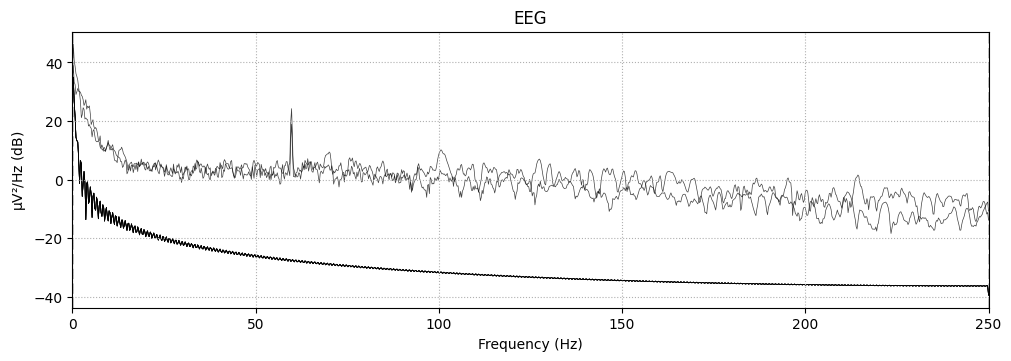

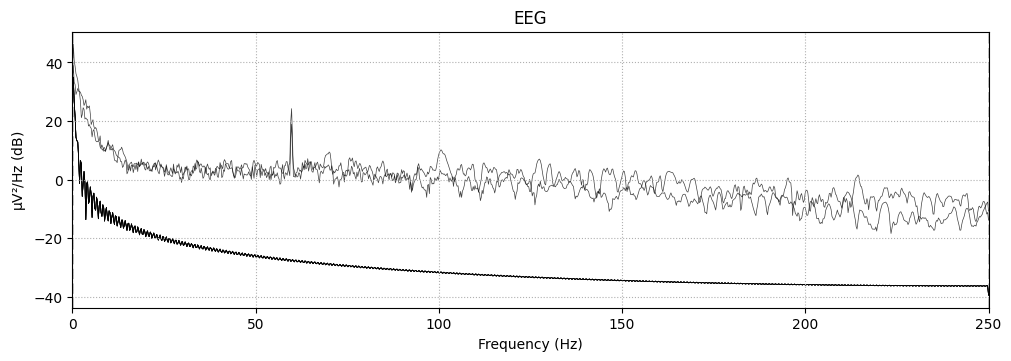

In [61]:
#plot power spectral density 
#ex of what the data looks like
eeg_check[75].plot_psd(tmin=None, tmax=None, proj=False, color='black', area_mode='std', dB=True)

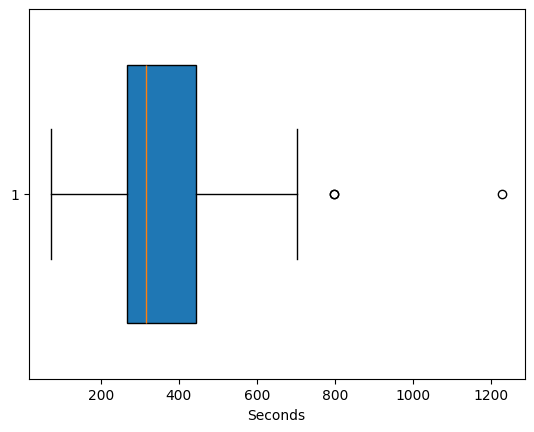

In [59]:
#looking at durations for clipping time -- will probably clip somewhere around the median
stats_dict = plt.boxplot(durations, vert=False, patch_artist=True, widths=0.7, showfliers=True)
plt.xlabel('Seconds')
plt.show()

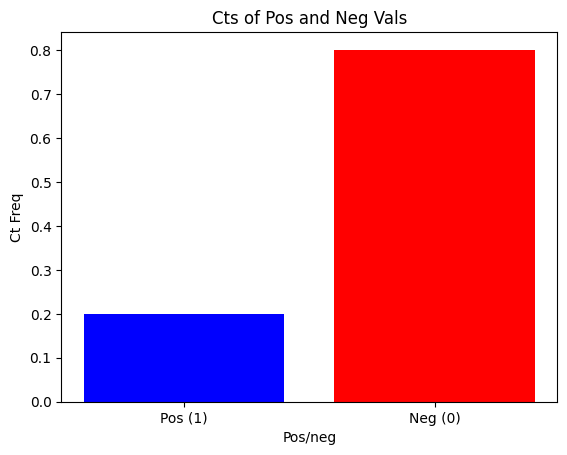

In [67]:
#looking at pos/neg distribution
total = len(df)
pos_ct = (df['Delirious (0=N, 1=Y)'] == '1').sum()/total
neg_ct = (df['Delirious (0=N, 1=Y)'] == '0').sum()/total
labels = ['Pos (1)', 'Neg (0)']
ct_freq = [pos_ct, neg_ct]

plt.bar(labels, ct_freq, color=['blue', 'red'])
plt.xlabel('Pos/neg')
plt.ylabel('Ct Freq')
plt.title('Cts of Pos and Neg Vals')
plt.show()

In [ ]:
#apply a bandpass filter to the data -- will do this when loading
def bandpass_filter(data, low_freq, high_freq, sfreq):
    return mne.filter.filter_data(data, sfreq, l_freq=low_freq, h_freq=high_freq, verbose='ERROR')